In [98]:
import pandas as pd
import numpy as np
from datetime import date, datetime, time, timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import shap
shap.initjs()

from sklearn.metrics import mean_squared_error

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

#models
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

 
mpl.rcParams['lines.linewidth'] = 2

figsize=(12,9)

np.random.seed(238746)


import warnings
warnings.filterwarnings("ignore")

In [99]:
SplitTestDate = "2018-12-02"

In [117]:
models = {
    #"linear" : LinearRegression(),
    "xgb" : xgb.XGBRegressor(n_estimators=500, learning_rate=0.5),
    "forest" : RandomForestRegressor(n_estimators=100,random_state=123),
    #"ada": AdaBoostRegressor(random_state=123, n_estimators=500)
    #"cat": CatBoostRegressor(iterations=20,learning_rate=0.5,eval_metric='MAPE')
}

features_for_model = {

    "xgb" : ['scaled_quarter','scaled_month','scaled_year','scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',
             'scaled_price_diff1','scaled_price',
             "BRAND2","BRAND4",
             'scaled_sales1','scaled_diff1','scaled_diff2','percentage_diff1',
             "scaled_rolling1","scaled_rolling2","scaled_rolling3","scaled_rolling4","scaled_rolling5",
             'scaled_promo'],
    "forest": ['scaled_quarter','scaled_month','scaled_year','scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',
             'scaled_price_diff1','scaled_price',
            "BRAND2","BRAND4",
             'scaled_sales1','scaled_sales2','scaled_diff1','scaled_diff2','percentage_diff1',
             "scaled_rolling2","scaled_rolling3",
             'scaled_promo'],
    "final": ['scaled_weekofyear',
             'scaled_sales1',
             "scaled_rolling2","scaled_rolling3",
             'scaled_promo']
}

#finalreg = LinearRegression()
finalreg = xgb.XGBRegressor(n_estimators=500, learning_rate=0.5)

In [118]:
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=123)
min_max_scaler = preprocessing.MinMaxScaler()

def scale(feature, scaler = min_max_scaler):
    size = len(feature)
    return scaler.fit_transform(np.array([feature]).reshape(size, 1)).T[0]
def unscale(scaled, original, scaler = min_max_scaler):
    size2 = len(scaled)
    size1 = len(original)
    return scaler.fit(np.array([original]).reshape(size1, 1)).inverse_transform(np.array([scaled]).reshape(size2, 1)).T[0]

In [119]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_results(ytrue, prediction, label):
    df_ytrue = pd.DataFrame(ytrue)
    df_ytrue['predicted'] =  prediction 
    plt.plot(df_ytrue[label],label='data')
    plt.plot(df_ytrue['predicted'],label='predicted')
    plt.xticks(rotation=45)
    mape = mean_absolute_percentage_error(df_ytrue[label],df_ytrue['predicted'])

    plt.title("Forecasting on Test Set MAPE=%.3f"%mape)
    plt.legend();
    plt.show()
    return mape
    
def plot_scaled_results(prediction, y_test, rescale):
    results = pd.DataFrame(columns = ["sku","target","prediction"])

    for sku in y_test["sku"].unique():

        pred_sku = prediction[np.where(y_test["sku"] == sku)]
        originals = rescale.loc[rescale["sku"] == sku]["target"]
        pred = unscale(pred_sku,originals)

        results = pd.concat([results, pd.DataFrame({
            "date" : y_test[y_test["sku"] == sku]["date"],
            "sku" : y_test[y_test["sku"] == sku]["sku"],
            "scaled_target" : y_test[y_test["sku"] == sku]["scaled_target"],
            "target" : y_test[y_test["sku"] == sku]["target"],
            "scaled_prediction" : pred_sku,
            "prediction" : pred
        })])
    results = results.dropna().set_index("date")

    return plot_results(results["target"], results["prediction"], "target"), results

In [132]:
def predict_training(model,X,y,label = "scaled_target",span = 24):
    
    #k = number of folds
    k = int(len(X_train)/span)
    
    prediction = pd.DataFrame(columns = ["date","sku","pred"])    
    
    for fold in range(0,k):
        if fold != k - 1:
            validation = X_train.iloc[fold*span:(fold+1)*span]
        else:
            validation = X_train.iloc[fold*span:]
        
        training = X_train[~X_train.index.isin(validation.index)]
        y_tr  = y_train[~y_train.index.isin(validation.index)]
        y_val  = y_train[y_train.index.isin(validation.index)]

        model.fit(training, y_tr[label])
        partial_pred = pd.DataFrame()
        partial_pred["date"] = y_val["date"]
        partial_pred["sku"] = y_val["sku"]
        partial_pred["pred"] = model.predict(validation)
        partial_pred.set_index(validation.index)
        prediction = prediction.append(partial_pred)
        
    return prediction

In [133]:
def StackingPred(models,final_model, X_train, y_train, X_test,features_for_model, span = 3, label = "scaled_target"):
    #TRAIN SET PREDICTION WITH MODELS
    results_dict = {}
    for name, model in models.items():
        print("predict training with " + name)
        X = X_train[features_for_model[name]]
        results_dict.update({name : predict_training(model, X, y_train,"scaled_target",span)})
    
    train_result = pd.DataFrame(index = y_train.index)
    for name,r in results_dict.items():
        train_result["date"] = r["date"]
        train_result["sku"] = r["sku"]
        train_result[name] = r["pred"]
    
    #TEST SET PREDICTION WITH MODELS
    prediction_df = pd.DataFrame()
    for name, model in models.items():
        print("predict test with " + name)
        X = X_train[features_for_model[name]]
        model = model.fit(X, y_train["scaled_target"]) 
        prediction_df[name] = model.predict(X_test[features_for_model[name]])
    prediction_df.index = X_test.index
    
    #DUMMY VARIABLES FOR FINAL TRAIN AND TEST
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoded = pd.get_dummies(train_result["sku"]) > 0
    onehot = pd.DataFrame(onehot_encoded, index = train_result.index)

    final_train = pd.concat([onehot,train_result[models.keys()]],axis = 1)

    onehot_encoded = pd.get_dummies(y_test["sku"]) > 0
    onehot = pd.DataFrame(onehot_encoded, index = y_test.index)
    final_test = pd.concat([onehot,prediction_df[models.keys()]],axis = 1)

    
    #TRAIN ON TRAIN PREDICTIONS AND PREDICTION ON TEST PREDICTIONS
    print("prediction with final")
    #finalreg = xgb.XGBRegressor(n_estimators=500, learning_rate=0.5)
    final_model.fit(final_train, y_train["scaled_target"])
    final_pred = final_model.predict(final_test)

    return final_pred

In [134]:
df_train = pd.read_csv('processed_train.csv',index_col = 0)
df_final_test = pd.read_csv('processed_test.csv',index_col = 0)

In [135]:
df_final_test.date = df_final_test.date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))
df_train.date = df_train.date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))
#df_train = df_train.loc[df_train.scope == 1]
group1 = [688, 1058, 549, 546, 1027, 554, 1035, 1206, 1065]
group2 = [144, 686, 1051]
df_train = df_train.loc[df_train["sku"].isin(group2)]

In [136]:
rescale_df = pd.concat([df_train,df_final_test])[["target","sku"]].dropna()

In [137]:
simple_df = df_train[['scaled_quarter','scaled_month','scaled_year','scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',
             'scaled_price_diff1','scaled_price',
            "BRAND2","BRAND4",
             'scaled_sales1','scaled_sales2','scaled_sales3','scaled_diff1','scaled_diff2','percentage_diff1',
             "scaled_rolling1","scaled_rolling2","scaled_rolling3","scaled_rolling4","scaled_rolling5",
             'scaled_promo',
                     "date","sku","scaled_target","target"]]

In [138]:
simple_df = simple_df.dropna().set_index("date")
df_train = simple_df[:SplitTestDate].reset_index()
df_test = simple_df[SplitTestDate:].reset_index()

In [139]:
X_train = df_train[['scaled_quarter','scaled_month','scaled_year','scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',
             'scaled_price_diff1','scaled_price',
            "BRAND2","BRAND4",
             'scaled_sales1','scaled_sales2','scaled_sales3','scaled_diff1','scaled_diff2','percentage_diff1',
             "scaled_rolling1","scaled_rolling2","scaled_rolling3","scaled_rolling4","scaled_rolling5",
             'scaled_promo']]

In [140]:
y_train = df_train[["date","sku","scaled_target","target"]]

In [141]:
X_test = df_test[['scaled_quarter','scaled_month','scaled_year','scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',
             'scaled_price_diff1','scaled_price',
            "BRAND2","BRAND4",
             'scaled_sales1','scaled_sales2','scaled_sales3','scaled_diff1','scaled_diff2','percentage_diff1',
             "scaled_rolling1","scaled_rolling2","scaled_rolling3","scaled_rolling4","scaled_rolling5",
             'scaled_promo']]

In [142]:
y_test = df_test[["date","sku","scaled_target","target"]]

In [143]:

res = StackingPred(models,finalreg, X_train, y_train, X_test,features_for_model, span = 9, label = "scaled_target")


predict training with xgb
predict training with forest
predict test with xgb
predict test with forest
prediction with final


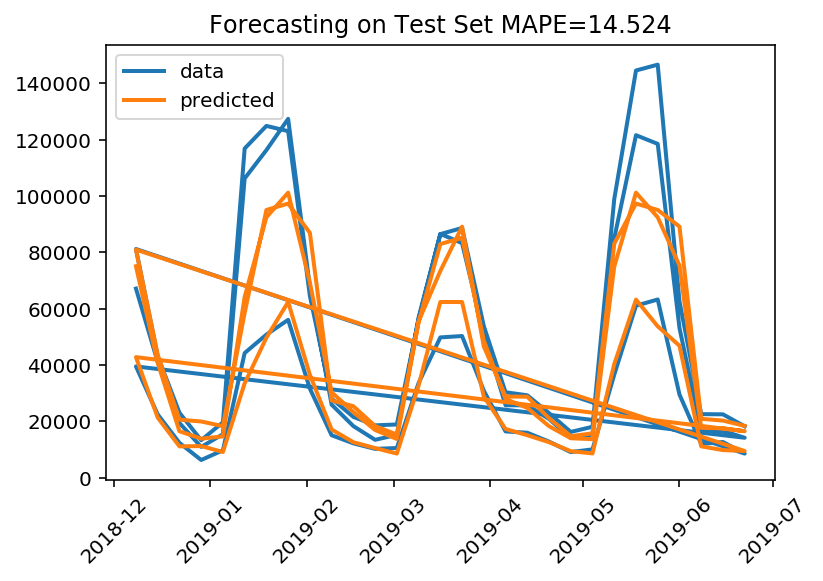

In [144]:
mape,results = plot_scaled_results(res, y_test, rescale_df)

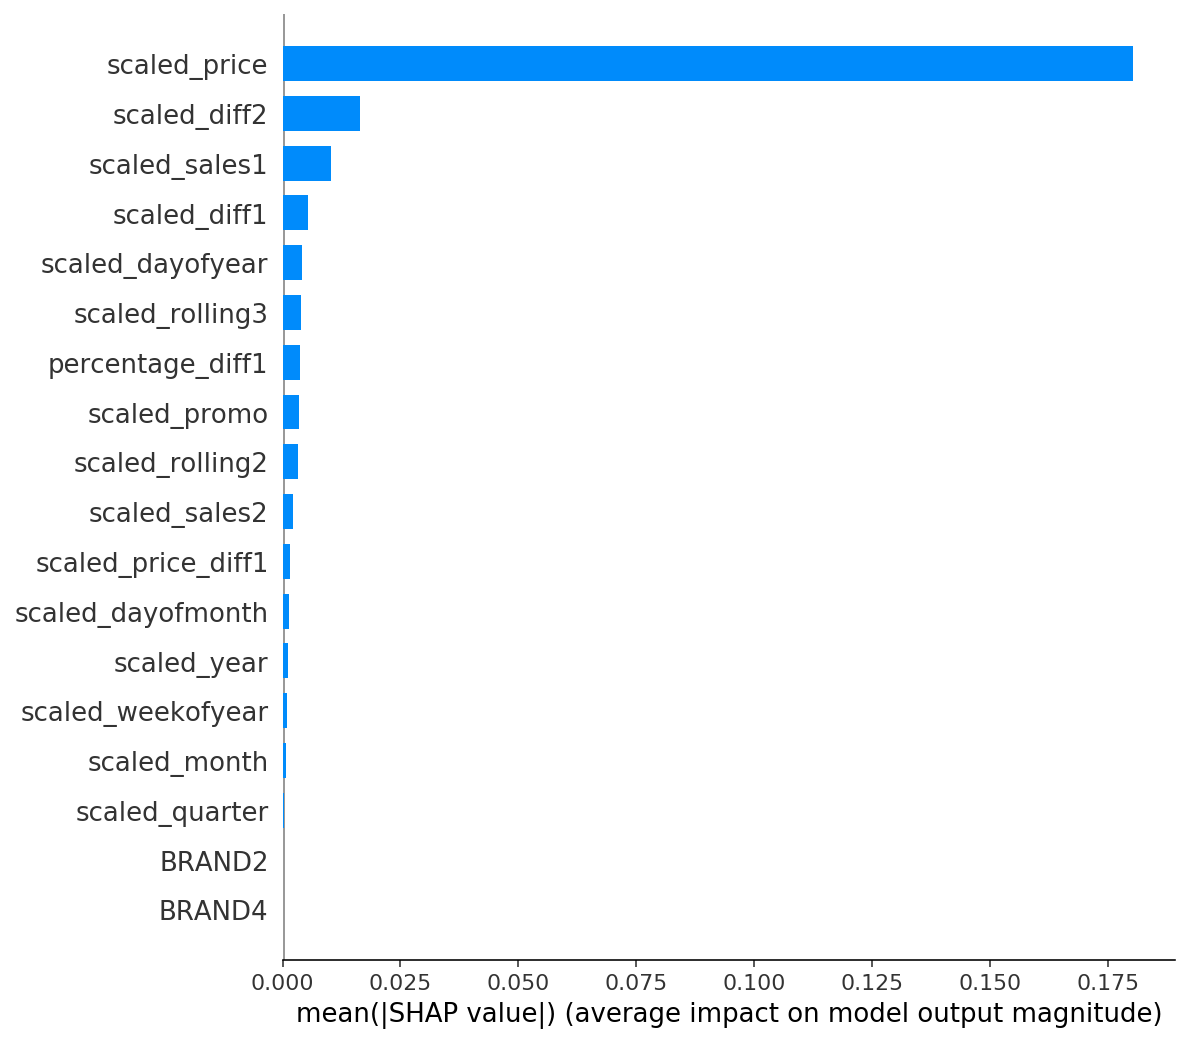

In [145]:
shap_values = shap.TreeExplainer(models["forest"]).shap_values(X_train[features_for_model["forest"]])
shap.summary_plot(shap_values, X_train[features_for_model["forest"]], plot_type="bar")

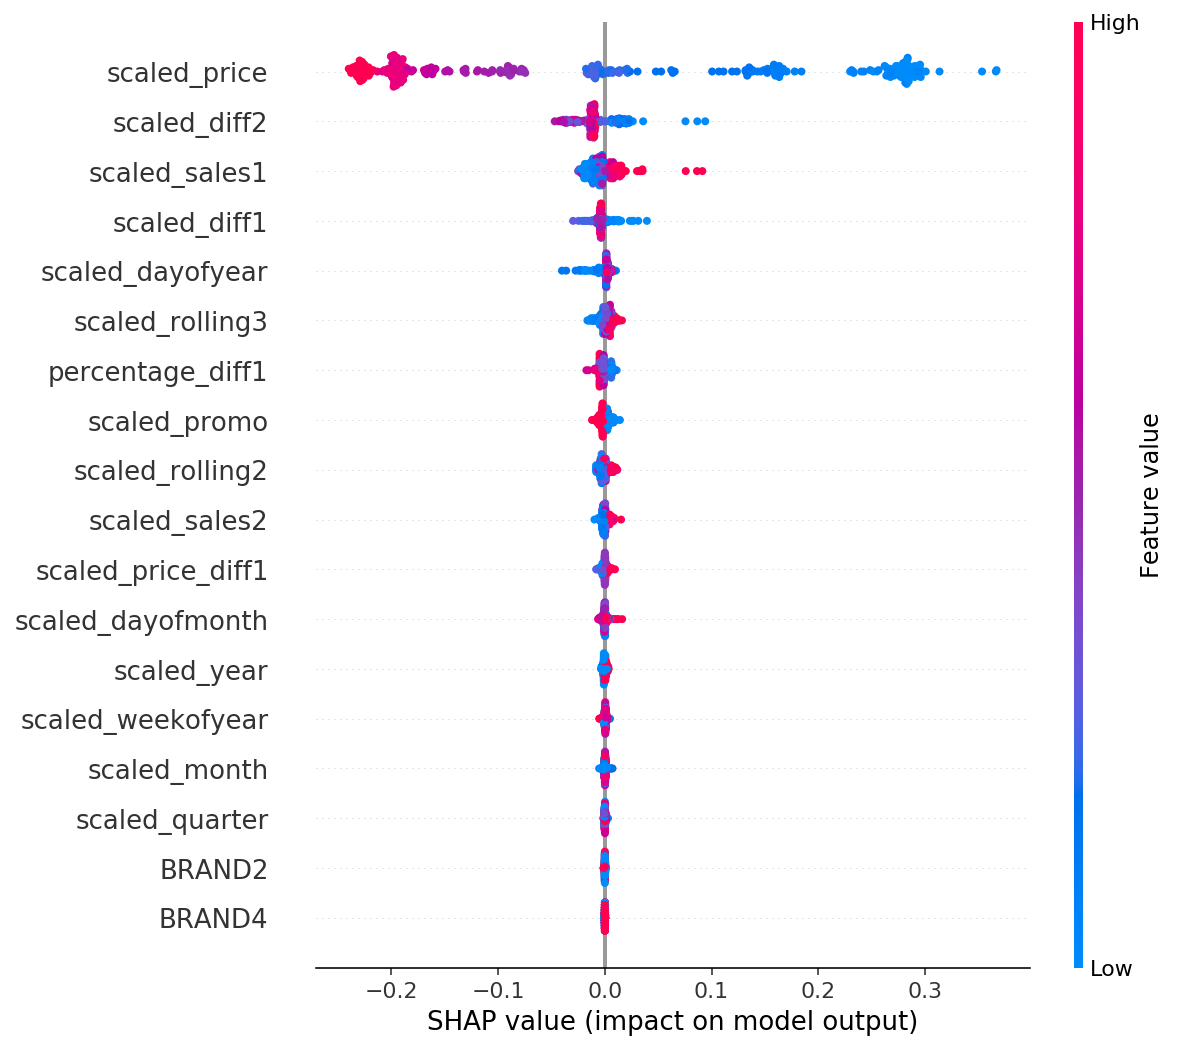

In [149]:
shap.summary_plot(shap_values, X_train[features_for_model["forest"]])


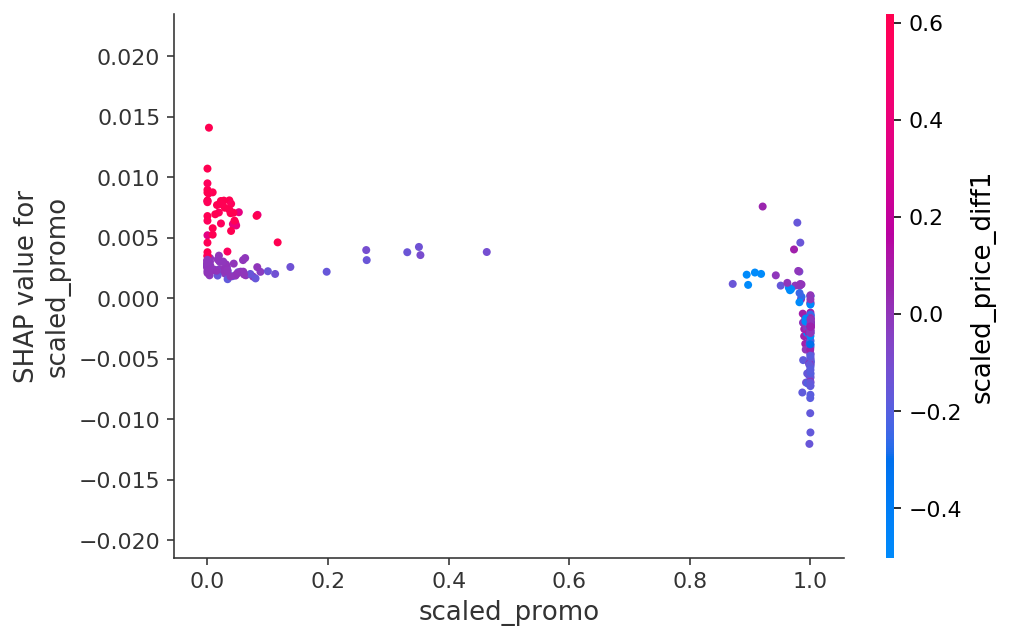

In [154]:
shap.dependence_plot("scaled_promo", shap_values, X_train[features_for_model["forest"]])

In [ ]:
importances = models["forest"].feature_importances_
std = np.std([tree.feature_importances_ for tree in models["forest"].estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(features_for_model["forest"])):
    print("%d. feature %s (%f)" % (f + 1, features_for_model["forest"][indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(len(features_for_model["forest"])), importances[indices],
       color="g", yerr=std[indices], align="center")
#plt.xticks(range(len(features_for_model["forest"])), np.array(features_for_model["forest"],order = indices),rotation=90)
plt.xlim([-1, features_for_model["forest"]])
plt.show()

In [ ]:
for s in results["sku"].unique():
    r = results.loc[results["sku"] == s]
    (r["scaled_target"] - r["scaled_prediction"]).plot()


In [ ]:
indices